In [73]:
from clusteringFunctions import *
from helpingFunctions import *
import pandas as pd
import os, re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
csv_data = pd.read_csv('/Users/amycweng/Digital Humanities/sermons.csv')
all_info = pd.read_csv('/Users/amycweng/Digital Humanities/Early-Modern-London/Relevant_Metadata/charityTCP.csv')
tcpIDs = [ _ for _ in csv_data['id']]
idToTitle = {}
for idx, title in enumerate(all_info['title']):
    curr_id = all_info['id'][idx]
    if curr_id in tcpIDs: 
        idToTitle[curr_id] = title  

In [19]:
def get_features(filePath,type): 
    '''
    Returns a dictionary in this format {id : features}
    '''
    readFile = open(filePath,'r')
    dict = {}
    for line in readFile:
        if type == 'citations': 
            tcpID =  line.split(' -- ')[0]
            features = line.split(' -- ')[1]
            features = re.sub('\n','',features)
            features = features.split('; ')
            if '' in features: features.remove('')
            dict[tcpID] = features
        else: 
            tcpID =  line.split(':')[0]
            features = line.split(':')[1]
            if type == 'topic' or type == 'ngrams': 
                features = re.sub('\n','',features)
                features = features.split(' ')
                if '' in features: features.remove('')
                dict[tcpID] = features
            elif type == 'subject': 
                final_features = []
                features = re.sub('\n','',features)
                features = features.split(' -- ')
                for feature in features: 
                    if not re.search('Sermons\, English|Early works to 1800.|17th century.|Sermons.|Sermons|Bible.',feature):
                        final_features.append(feature.strip())
                if '' in features: final_features.remove('')
                dict[tcpID] = final_features
    readFile.close()
    return dict

def count_features(feature_dict,ids,type=''): 
    all_features = []
    for tcpID, features in feature_dict.items(): 
        if tcpID in ids and len(features) > 0: 
            all_features.extend(features)
    if type == 'all citations': 
        print(f'\tThere are {len(all_features)} marginal citations in total.')
    elif type == 'charity citations': 
        print(f'\tThere are {len(all_features)} marginal citations relating to charity.')

    return Counter(all_features).most_common(n=20)

def find_titles(ids_list): 
    titles_list = [] 
    for tcpID in ids_list: 
        title = idToTitle[tcpID]
        title = title.split(' ')
        titles_list.append(f'{tcpID}: {" ".join(title[0:10])}')
    return titles_list

TFIDF vectorization and clustering of the cleaned texts in the Charity Sermons dataset

In [32]:
textInfo = getTexts('/Users/amycweng/Digital Humanities/charityTXT',tcpIDs,True)
print(len(textInfo))

70


In [105]:
vector = TfidfVectorizer(norm=None, sublinear_tf=True)
tfidf_results = vector.fit_transform(textInfo.values())
df = pd.DataFrame(tfidf_results.toarray(), index=textInfo.keys(), columns=vector.get_feature_names()) 

In [103]:
def top_terms(tcpIDs,sourceIds,results):
    top_list = []
    for tcpID in tcpIDs: 
        single_text_df = pd.DataFrame(results[[_ for _ in sourceIds].index(tcpID)].T.todense(), index=vector.get_feature_names(), columns=[tcpID])
        single_text_df = single_text_df.sort_values(tcpID, ascending=False)
        single_text_df = single_text_df[single_text_df[tcpID] != 0]
        top = list(single_text_df.head(25).T.columns)
        top_list.extend(top)
    return(top_list)

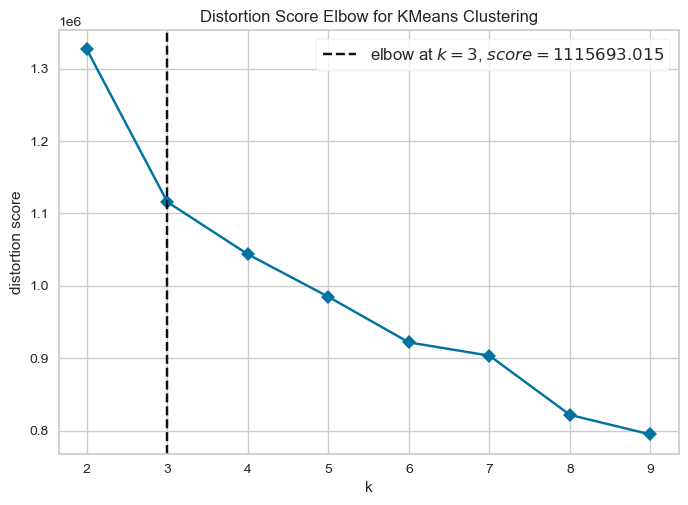

In [111]:
'''Clustering based only on the original texts (no other features)'''
elbow(df)

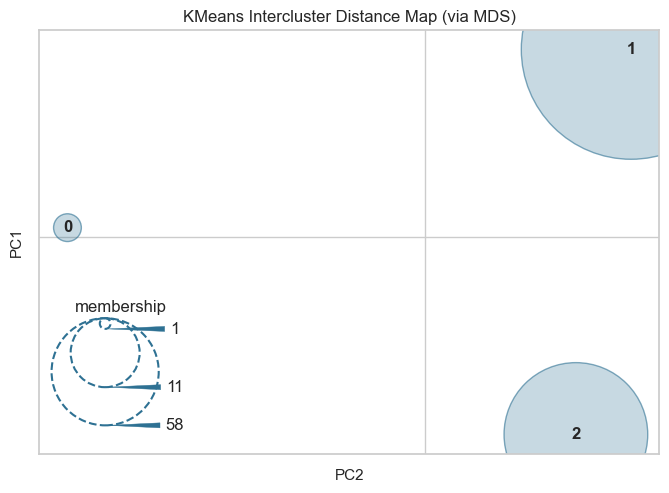

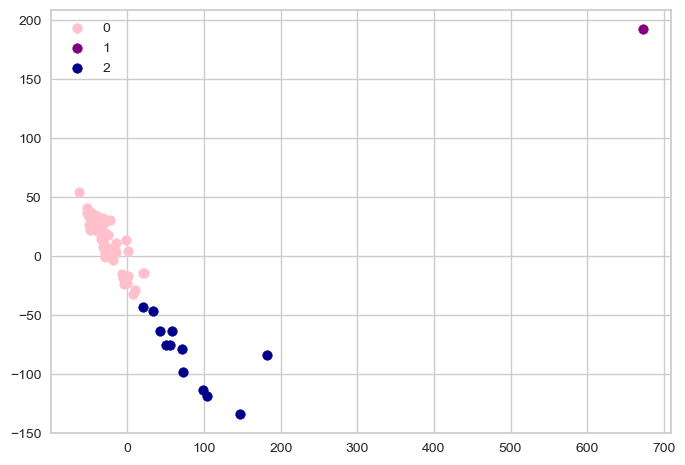

<Figure size 2000x1000 with 0 Axes>

In [107]:
intercluster(df,3)
groups = pca_cluster(df,3,tcpIDs)

In [108]:
important_info = pd.read_csv('/Users/amycweng/Digital Humanities/Early-Modern-London/Sermons_Info/audience.location.etc.csv')
location, audience, help_poor = {}, {}, {}
for idx, tcpID in enumerate(important_info['id']):
    location[tcpID] = [important_info['location_name'][idx]]
    audience[tcpID] = [important_info['audience'][idx]]
    help_poor[tcpID] = [important_info['help_poor'][idx]]

In [5]:
topics = get_features('/Users/amycweng/Digital Humanities/Early-Modern-London/Sermons_Info/topics.charity.sermons.txt','topic')
subjects = get_features('/Users/amycweng/Digital Humanities/Early-Modern-London/Sermons_Info/sermons.subject.headings.txt','subject')
all_citations = get_features('/Users/amycweng/Digital Humanities/Early-Modern-London/Sermons_Info/marginalia.all.sermons.txt','citations')
charity_citations = get_features('/Users/amycweng/Digital Humanities/Early-Modern-London/Sermons_Info/marginalia.charity.sermons.txt','citations')
ngrams = get_features('/Users/amycweng/Digital Humanities/Early-Modern-London/Sermons_Info/gramsEachcharityText.txt','ngrams')

In [115]:
for groupNum, ids_list in groups.items(): 
    if len(ids_list) == 1:
        print(f'There is {len(ids_list)} text in Group {groupNum}')
    else: 
        print(f'There are {len(ids_list)} texts in Group {groupNum}')
    if groupNum != 0: 
        print(f'\tTitles: {find_titles(ids_list)}')
        print(f'\tGroup {groupNum} TCP IDs: {ids_list}')
    print(f'\tThe locations for the texts in this cluster: {count_features(location,ids_list)}')
    print(f'\tThe audiences for the texts in this cluster: {count_features(audience,ids_list)}')
    print(f'\tWhether or not the text mentions the provision of material help to the needy: {count_features(help_poor,ids_list)}')
    print(f'\tTop 20 TFIDF terms for the texts within this cluster: {Counter(top_terms(ids_list,textInfo.keys(),tfidf_results)).most_common(n=20)}')

    print(f'\tTop 20 Bigrams and Trigrams of Keywords: {count_features(ngrams,ids_list)}')
    print(f'\tTop 20 Topic Words: {count_features(topics,ids_list)}')
    print(f'\tAll subject headings: {count_features(subjects,ids_list)}')

    print(f'\tTop 20 Biblical/Apocryphal Citations: {count_features(all_citations,ids_list,"all citations")}')
    print(f'\tTop 20 Biblical/Apocryphal Citations Relating to Charity: {count_features(charity_citations,ids_list,"charity citations")}.\n\n')

There are 12 texts in Group 2
	Titles: ['A68088: Tvvo funeral sermons much of one and the same subiect;', 'A41670: A learned and very useful commentary on the whole epistle', 'A55748: The mysticall match between Christ and his church by the', 'A10010: The saints qualification: or A treatise I. Of humiliation, in', 'A09958: The doctrine of the saints infirmities Delivered in severall sermons', "A86974: A sermon preach't to his Maiesty, at the court of", 'A01533: Gods parley vvith princes with an appeale from them to', "A70130: Mercies memorial set out in a sermon preached in Paul's", 'A01530: Maskil le-David = Dauids instructer A sermon preached at the', 'A02591: The true peace-maker laid forth in a sermon before his', 'A15010: The oyle of gladnesse. Or, Comfort for dejected sinners First', 'A15012: The poore mans advocate, or, A treatise of liberality to']
	Group 2 TCP IDs: ['A68088', 'A41670', 'A55748', 'A10010', 'A09958', 'A86974', 'A01533', 'A70130', 'A01530', 'A02591', 'A15010', 'A

In [72]:
'''Comparison of the performance of the TFIDF Transformer + Count Vectorizer vs. only the TfidfVectorizer'''
tcpID = 'A55754'
single_text_df = pd.DataFrame(tfidf_results[[_ for _ in textInfo.keys()].index(tcpID)].T.todense(), index=vector.get_feature_names(), columns=[tcpID])
single_text_df = single_text_df.sort_values(tcpID, ascending=False)
top_tfidf = list(single_text_df.head(25).T.columns)
print(f'Method A (sublinear TF & no normalization): ', top_tfidf)

vector = TfidfVectorizer()
tfidf_results = vector.fit_transform(textInfo.values())
single_text_df = pd.DataFrame(tfidf_results[[_ for _ in textInfo.keys()].index(tcpID)].T.todense(), index=vector.get_feature_names(), columns=[tcpID])
single_text_df = single_text_df.sort_values(tcpID, ascending=False)
top_tfidf = list(single_text_df.head(25).T.columns)
print(f'Method B (default): ', top_tfidf)

Method A (sublinear TF & no normalization):  ['arminius', 'execration', 'stafford', 'preston', 'fullness', 'accurse', 'maranatha', 'anathema', 'treatise', 'sup', 'hater', 'dominion', 'forgive', 'sabboath', 'dd', 'love', 'aswell', 'godliness', 'ebal', 'tabor', 'olivet', 'matthew', 'spouse', 'god', 'sign']
Method B (default):  ['love', 'god', 'lord', 'sin', 'christ', 'heart', 'grace', 'fullness', 'take', 'good', 'give', 'power', 'jesus', 'godliness', 'faith', 'spirit', 'desire', 'receive', 'believe', 'forgive', 'accurse', 'show', 'curse', 'work', 'keep']


The code below shows the TFIDF vectorization and clustering of all marginal citations in the Charity Sermons Dataset

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


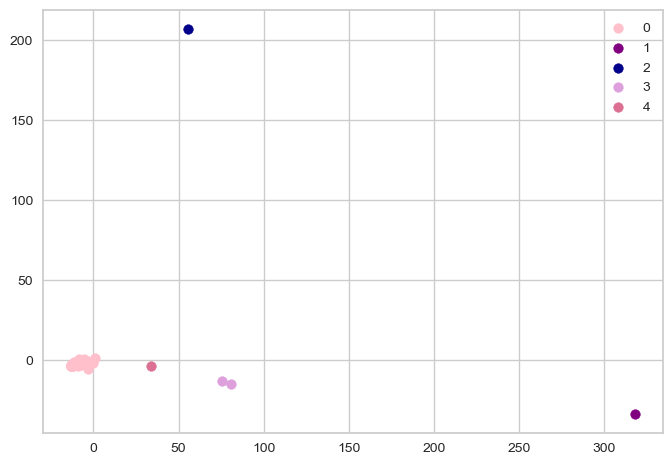

<Figure size 2000x1000 with 0 Axes>

In [142]:
cited = {}
for tcpID, c_list in all_citations.items(): 
    citations = []
    if len(c_list) == 0: 
        continue
    for passage in c_list: 
        '''Transform the citation into one unit using underscores'''
        passage = re.sub(':','_',passage)
        passage = passage.split(' ')
        passage = '_'.join(passage)
        citations.append(passage)        
        '''Extracting only the book'''
        # book = passage.split(' ')
        # if book[0] == '1' or book[0] == '2': 
        #     citations.append(f'{book[0]}_{book[1]}')
        # else: 
        #     citations.append(f'{book[0]}')
        '''Extracting only the chapter'''
        # book = passage.split(' ')
        # if book[0] == '1' or book[0] == '2': 
        #     book[2] = book[2].split(':')[0]
        #     citations.append(f'{book[0]}_{book[1]}_{book[2]}')
        # else: 
        #     book[1] = book[1].split(':')[0]
        #     citations.append(f'{book[0]}_{book[1]}')
    cited[tcpID] = ' '.join(citations)
'''Tfidf vectorization'''
vector = TfidfVectorizer(norm=None, sublinear_tf=True)
tfidf_results = vector.fit_transform(cited.values())
df = pd.DataFrame(tfidf_results.toarray(), index=cited.keys(), columns=vector.get_feature_names()) 
# elbow(df)
# intercluster(df,3)
groups = pca_cluster(df,5,cited.keys())

In [143]:
for groupNum, ids_list in groups.items(): 
    if len(ids_list) == 1:
        print(f'There is {len(ids_list)} text in Group {groupNum}')
    else: 
        print(f'There are {len(ids_list)} texts in Group {groupNum}')
    if groupNum != 0: 
        print(f'Titles: {find_titles(ids_list)}')
    print(f'Group {groupNum} TCP IDs: {ids_list}')
    print(f'\tThe audiences for the texts in this cluster: {count_features(audience,ids_list)}')
    print(f'\tWhether or not the text mentions the provision of material help to the needy: {count_features(help_poor,ids_list)}')
    print(f'\tHere are the top 10 terms of each cluster: {Counter(top_terms(ids_list,cited.keys(),tfidf_results)).most_common(n=10)}\n\n')

There are 55 texts in Group 0
Group 0 TCP IDs: ['A09990', 'A02547', 'A09963', 'A02565', 'A85485', 'A09981', 'A10010', 'A09965', 'A70130', 'A09950', 'A10024', 'A14989', 'A01531', 'A01530', 'A02591', 'A01547', 'A55750', 'A01970', 'A19588', 'A19589', 'A02537', 'A15010', 'A01528', 'A85486', 'A68877', 'A85487', 'A15003', 'A55748', 'A01523', 'A19590', 'A09999', 'A15015', 'A01548', 'A01534', 'A02571', 'A55754', 'A09977', 'A10030', 'A01538', 'A86974', 'A15012', 'A01533', 'A14996', 'A09970', 'A09971', 'A41670', 'A10027', 'A01980', 'A10018', 'A02585', 'A09958', 'A01524', 'A68088', 'A09967', 'A01553']
	The audiences for the texts in this cluster: [('local', 29), ('funeral', 6), ('monarch', 6), ('house of lords', 3), ('wedding', 3), ('historical', 3), ('company', 2), ('hospital', 1), ('house of commons', 1), ('school', 1)]
	Whether or not the text mentions the provision of material help to the needy: [(True, 30), (False, 25)]


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


	Here are the top 10 terms of each cluster: [('john_15_2', 3), ('1_corinthians_1_30', 3), ('hebrews_9_14', 2), ('proverbs_31_29', 2), ('john_5_21', 2), ('john_15_1', 2), ('john_11_44', 2), ('john_11_43', 2), ('romans_9_15', 2), ('john_15_3', 2)]


There is 1 text in Group 1
Titles: ['A72143: Certaine sermons, first preached, and after published at severall times,']
Group 1 TCP IDs: ['A72143']
	The audiences for the texts in this cluster: [('local', 1)]
	Whether or not the text mentions the provision of material help to the needy: [(True, 1)]
	Here are the top 10 terms of each cluster: [('matthew_24_42', 1), ('galatians_6_3', 1), ('mark_13_35', 1), ('deuteronomy_30_20', 1), ('matthew_25_13', 1), ('psalms_4_4', 1), ('hebrews_6_10', 1), ('psalms_68_4', 1), ('psalms_2_11', 1), ('psalms_32_11', 1)]


There are 2 texts in Group 3
Titles: ['A01529: The Christian mans care A sermon on Matth. 6. 33.', 'A01539: the ioy of the iust vvith the signes of such.']
Group 3 TCP IDs: ['A01529', 'A01539']

The code below shows the TFIDF vectorization and clustering of marginal citations related to charity in the Charity Sermons Dataset

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


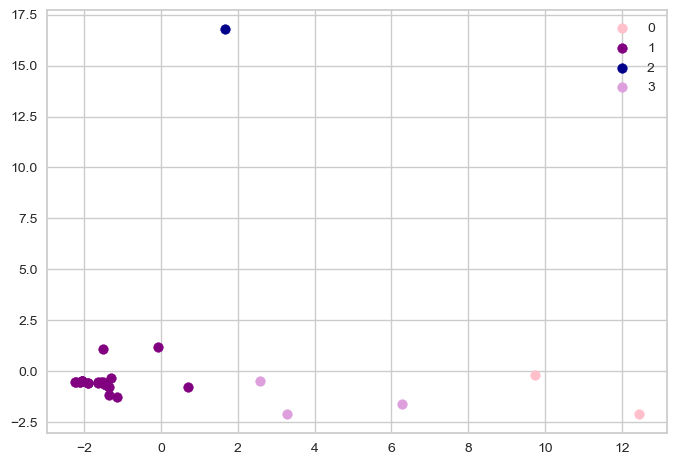

<Figure size 2000x1000 with 0 Axes>

In [147]:
cited = {}
for tcpID, c_list in charity_citations.items(): 
    if len(c_list) == 0: 
        continue
    citations = []
    for passage in c_list: 
        '''Transform the citation into one unit using underscores'''
        passage = re.sub(':','_',passage)
        passage = passage.split(' ')
        passage = '_'.join(passage)
        citations.append(passage)        
    cited[tcpID] = ' '.join(citations)
'''Tfidf vectorization'''
vector = TfidfVectorizer(norm=None, sublinear_tf=True)
tfidf_results = vector.fit_transform(cited.values())
df = pd.DataFrame(tfidf_results.toarray(), index=cited.keys(), columns=vector.get_feature_names()) 
# elbow(df)
groups = pca_cluster(df,4,cited.keys())

In [148]:
for groupNum, ids_list in groups.items(): 
    if len(ids_list) == 1:
        print(f'There is {len(ids_list)} text in Group {groupNum}')
    else: 
        print(f'There are {len(ids_list)} texts in Group {groupNum}')
    if groupNum != 1: 
        print(f'Titles: {find_titles(ids_list)}')
    print(f'Group {groupNum} TCP IDs: {ids_list}')
    print(f'\tThe audiences for the texts in this cluster: {count_features(audience,ids_list)}')
    print(f'\tWhether or not the text mentions the provision of material help to the needy: {count_features(help_poor,ids_list)}')
    print(f'\tHere are the top 10 terms of each cluster: {Counter(top_terms(ids_list,cited.keys(),tfidf_results)).most_common(n=10)}\n\n')

There are 23 texts in Group 1
Group 1 TCP IDs: ['A85485', 'A09965', 'A09950', 'A10024', 'A01530', 'A01547', 'A19588', 'A19589', 'A01528', 'A85487', 'A01523', 'A19590', 'A01554', 'A15015', 'A01534', 'A02571', 'A09977', 'A01539', 'A01533', 'A14996', 'A09971', 'A01524', 'A68088']
	The audiences for the texts in this cluster: [('local', 13), ('funeral', 4), ('company', 1), ('house of commons', 1), ('wedding', 1), ('historical', 1), ('house of lords', 1), ('school', 1)]
	Whether or not the text mentions the provision of material help to the needy: [(True, 16), (False, 7)]
	Here are the top 10 terms of each cluster: [('acts_20_35', 3), ('proverbs_22_2', 3), ('isaiah_58_7', 3), ('1_john_3_17', 2), ('matthew_10_42', 2), ('job_31_22', 2), ('job_31_21', 2), ('galatians_6_10', 2), ('romans_12_8', 2), ('isaiah_61_1', 2)]


There are 2 texts in Group 0
Titles: ['A72143: Certaine sermons, first preached, and after published at severall times,', "A01531: The decease of Lazarus Christ's friend A funer

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Vectorization and clustering of the context windows (20 words before and after) around key terms

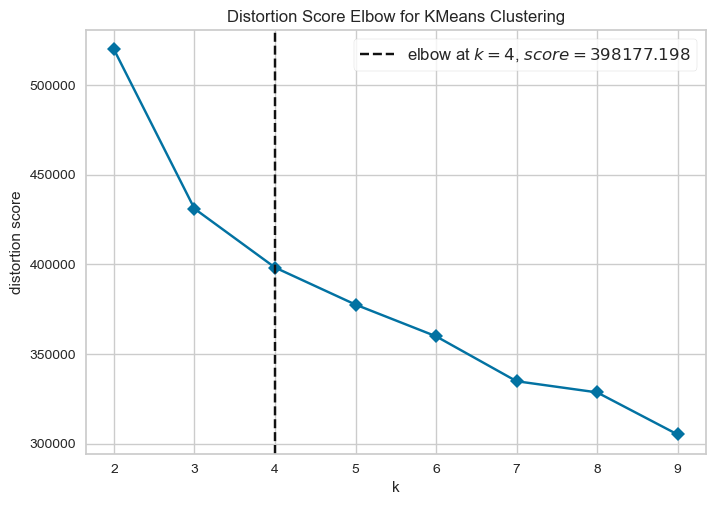

In [167]:
contexts = getTexts('/Users/amycweng/Digital Humanities/charityContexts',tcpIDs,False)
vector = TfidfVectorizer(norm=None, sublinear_tf=True)
tfidf_results = vector.fit_transform(contexts.values())
df = pd.DataFrame(tfidf_results.toarray(), index=contexts.keys(), columns=vector.get_feature_names()) 
elbow(df)

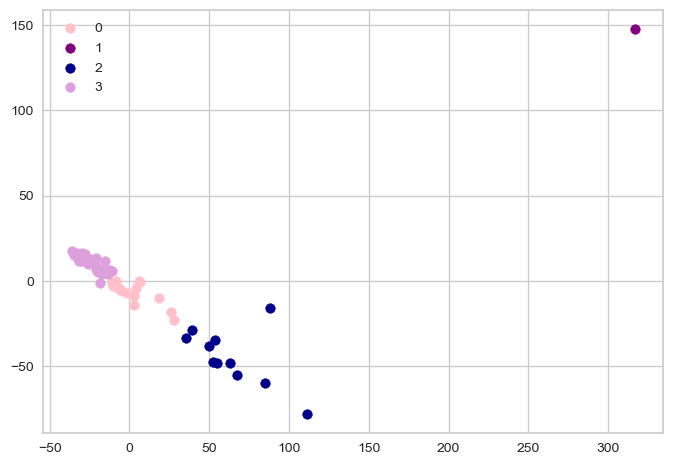

<Figure size 2000x1000 with 0 Axes>

In [165]:
groups = pca_cluster(df,4,tcpIDs)

In [166]:
for groupNum, ids_list in groups.items(): 
    if len(ids_list) == 1:
        print(f'There is {len(ids_list)} text in Group {groupNum}')
    else: 
        print(f'There are {len(ids_list)} texts in Group {groupNum}')
    # if groupNum != 1: 
    #     print(f'Titles: {find_titles(ids_list)}')
    print(f'Group {groupNum} TCP IDs: {ids_list}')
    print(f'\tThe audiences for the texts in this cluster: {count_features(audience,ids_list)}')
    print(f'\tWhether or not the text mentions the provision of material help to the needy: {count_features(help_poor,ids_list)}')
    print(f'\tHere are the top 10 terms of each cluster: {Counter(top_terms(ids_list,contexts.keys(),tfidf_results)).most_common(n=10)}\n\n')

There are 11 texts in Group 2
Group 2 TCP IDs: ['A68088', 'A01523', 'A41670', 'A55748', 'A10010', 'A09958', 'A86974', 'A01533', 'A01530', 'A02591', 'A15012']
	The audiences for the texts in this cluster: [('local', 6), ('funeral', 2), ('monarch', 2), ('school', 1)]
	Whether or not the text mentions the provision of material help to the needy: [(True, 6), (False, 5)]
	Here are the top 10 terms of each cluster: [('disobedience', 2), ('justice', 2), ('drsse', 1), ('crop', 1), ('trash', 1), ('mortality', 1), ('dung', 1), ('beginning', 1), ('death', 1), ('payment', 1)]


There are 17 texts in Group 0
Group 0 TCP IDs: ['A01538', 'A01539', 'A09971', 'A10015', 'A10030', 'A10024', 'A02519', 'A19589', 'A02571', 'A72143', 'A01553', 'A01524', 'A01554', 'A70130', 'A85485', 'A02517', 'A15010']
	The audiences for the texts in this cluster: [('local', 10), ('monarch', 2), ('historical', 2), ('funeral', 1), ('wedding', 1), ('house of lords', 1)]
	Whether or not the text mentions the provision of materi

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


	Here are the top 10 terms of each cluster: [('charity', 3), ('sword', 3), ('prayer', 3), ('heap', 3), ('humiliation', 3), ('action', 3), ('husband', 3), ('sleep', 3), ('religious', 3), ('pound', 2)]


There is 1 text in Group 1
Group 1 TCP IDs: ['A55754']
	The audiences for the texts in this cluster: [('local', 1)]
	Whether or not the text mentions the provision of material help to the needy: [(True, 1)]
	Here are the top 10 terms of each cluster: [('stafford', 1), ('thomas', 1), ('fullness', 1), ('print', 1), ('accurse', 1), ('sabboath', 1), ('matthew', 1), ('love', 1), ('curse', 1), ('annex', 1)]


